**Mini-batch gradient descent is prefeered over batch gradient descent in which the parameters are updated after one full pass through the entire data. Mini-batch gradient descent is memory efficient and better convergence.**

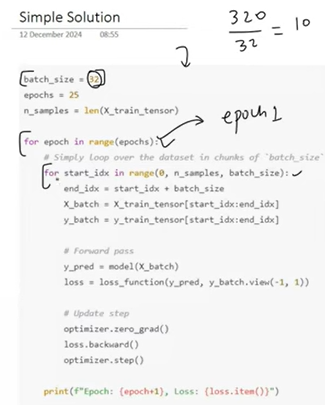

**Problem with the above approach of manual division into mini-batches for more frequent and efficient training poses few problems:**

*   No standard inference for data stored in several files/folers on our computer.
*   No easy way to apply transformations directly when data loading.
*   Shuffling nd Sampling.
*   Batch management & Parallelism





**Dataset and Dataloader class**

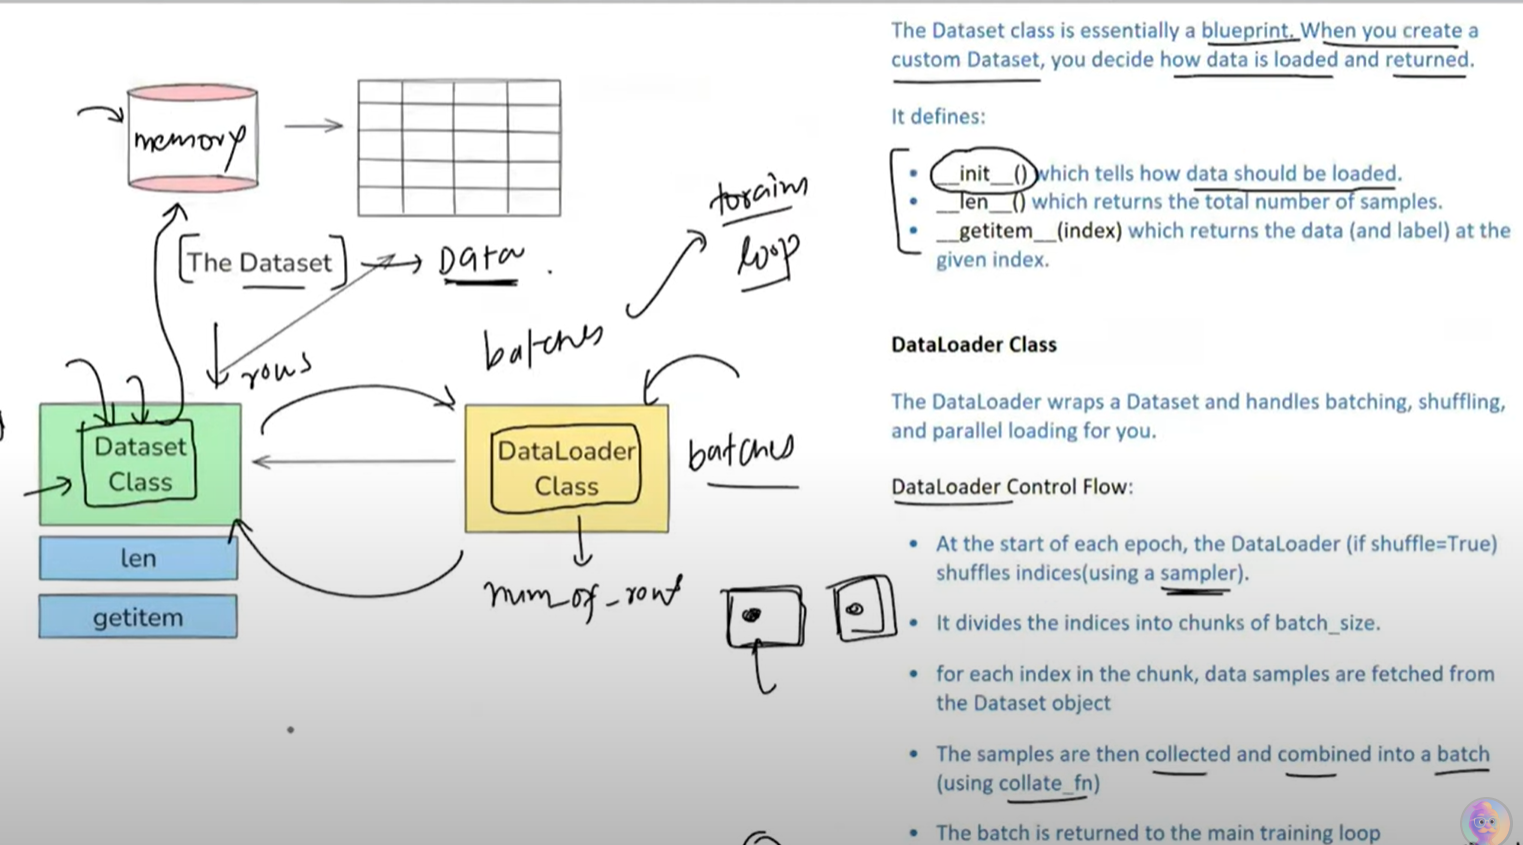

In [ ]:
from sklearn.datasets import make_classification
import torch

In [ ]:
# Step 1: Create a synthetic classification dataset using sklearn
X, y = make_classification(
    n_samples = 10,          # Number of samples
    n_features = 2,         # Number of features
    n_informative = 2,      # Number of informative features
    n_redundant = 0,        # Number of redundant features
    n_classes = 2,          # Number of classes
    random_state = 42       # For reproducibility
)

In [ ]:
X

array([[ 1.06833894, -0.97007347],
       [-1.14021544, -0.83879234],
       [-2.8953973 ,  1.97686236],
       [-0.72063436, -0.96059253],
       [-1.96287438, -0.99225135],
       [-0.9382051 , -0.54304815],
       [ 1.72725924, -1.18582677],
       [ 1.77736657,  1.51157598],
       [ 1.89969252,  0.83444483],
       [-0.58723065, -1.97171753]])

In [ ]:
X.shape

(10, 2)

In [ ]:
y

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
y.shape

(10,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
type(y)

numpy.ndarray

In [ ]:
# Convert the data to PyTorch tensors

X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.long)

In [ ]:
X

tensor([[ 1.0683, -0.9701],
        [-1.1402, -0.8388],
        [-2.8954,  1.9769],
        [-0.7206, -0.9606],
        [-1.9629, -0.9923],
        [-0.9382, -0.5430],
        [ 1.7273, -1.1858],
        [ 1.7774,  1.5116],
        [ 1.8997,  0.8344],
        [-0.5872, -1.9717]])

In [ ]:
y

tensor([1, 0, 0, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class CustomDataset(Dataset):

  def __init__(self, features, labels):

    self.features = features
    self.labels = labels

  def __len__(self):

    return len(self.features)

  def __getitem__(self, idx):

    return self.features[idx], self.labels[idx]

In [ ]:
dataset = CustomDataset(X, y)

In [ ]:
len(dataset)

10

In [ ]:
dataset[2]

(tensor([-2.8954,  1.9769]), tensor(0))

In [ ]:
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True)

In [ ]:
for batch_features, batch_labels in dataloader:

  print(batch_features)
  print(batch_labels)
  print("-"*50)

tensor([[ 1.7774,  1.5116],
        [-0.5872, -1.9717]])
tensor([1, 0])
--------------------------------------------------
tensor([[-2.8954,  1.9769],
        [-0.9382, -0.5430]])
tensor([0, 1])
--------------------------------------------------
tensor([[-1.9629, -0.9923],
        [ 1.7273, -1.1858]])
tensor([0, 1])
--------------------------------------------------
tensor([[ 1.0683, -0.9701],
        [-0.7206, -0.9606]])
tensor([1, 0])
--------------------------------------------------
tensor([[ 1.8997,  0.8344],
        [-1.1402, -0.8388]])
tensor([1, 0])
--------------------------------------------------


Transformations to each data item can be done before returning the required data itemby using it's index in the __getitem__ method of CustomDataset class

Imagine the entire data loading and training process for one epoch with num_workers=4:

##Assumptions:

• Total samples: 10,000

• Batch size: 32

• Workers (num_workers): 4

• Approximately 312 full batches per epoch (10000 / 32 ≈ 312).

#**Workflow:**

1.   **Sampler and Batch Creation (Main Process):**

Before training starts for the epoch, the DataLoader’s sampler generates a shuffled list of all 10,000 indices. These
are then grouped into 312 batches of 32 indices each. All these batches are queued up, ready to be fetched by
workers.

2.   **Parallel Data Loading (Workers):**

At the start of the training epoch, you run a training loop like:

    for batch_data, batch_labels in dataloader:
       #Training logic

○  Under the hood, as soon as you start iterating over dataloader, it dispatches the first four batches of indices
to the four workers:

▪ Worker #1 loads batch 1 (indices [batch_1_indices])

▪ Worker #2 loads batch 2 (indices [batch_2_indices])

▪ Worker #3 loads batch 3 (indices [batch_3_indices])

▪ Worker #4 loads batch 4 (indices [batch_4_indices])




Each worker:

○ Fetches the corresponding samples by calling __getitem__ on the dataset for each index in that batch.

○ Applies any defined transforms and passes the samples through collate_fn to form a single batch tensor.


3.   **First Batch Returned to Main Process:**

○   Whichever worker finishes first sends its fully prepared batch (e.g., batch 1) back to the main process.

○   As soon as the main process gets this first prepared batch, it yields it to your training loop, so your code for
batch_data, batch_labels in dataloader: receives (batch_data, batch_labels) for the first batch.



4.   **Model Training on the Main Process:**

○  While you are now performing the forward pass, computing loss, and doing backpropagation on the first
batch, the other three workers are still preparing their batches in parallel.

○ By the time you finish updating your model parameters for the first batch, the DataLoader likely has the
second, third, or even more batches ready to go (depending on processing speed and hardware).



5.  **Continuous Processing:**

○ As soon as a worker finishes its batch, it grabs the next batch of indices from the queue.

○ For example, after Worker #1 finishes with batch 1, it immediately starts on batch 5. After Worker #2
finishes batch 2, it takes batch 6, and so forth.

○ This creates a pipeline effect: at any given moment, up to 4 batches are being prepared concurrently.



6.  **Loop Progression:**

○  Your training loop simply sees:

    for batch_data, batch_labels in dataloader:
      # forward pass
      # loss computation
      # backward pass
      # optimizer step
○  Each iteration, it gets a new, ready-to-use batch without long I/O waits, because the workers have been pre-
loading and processing data in parallel.



7.  **End of the Epoch:**

○  After ~312 iterations, all batches have been processed. All indices have been consumed, so the DataLoader
has no more batches to yield.

○   The epoch ends. If shuffle=True, on the next epoch, the sampler reshuffles indices, and the whole process
repeats with workers again loading data in parallel.

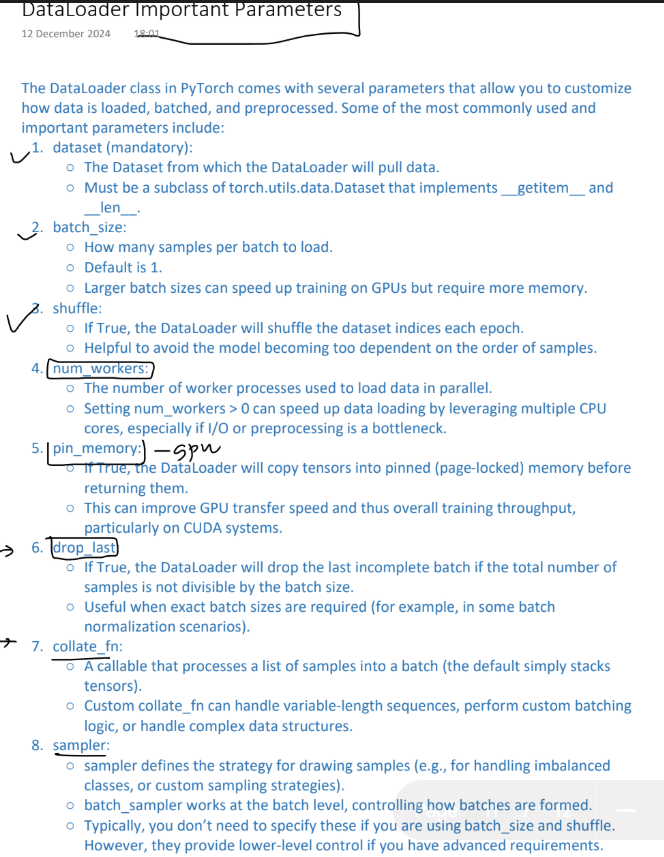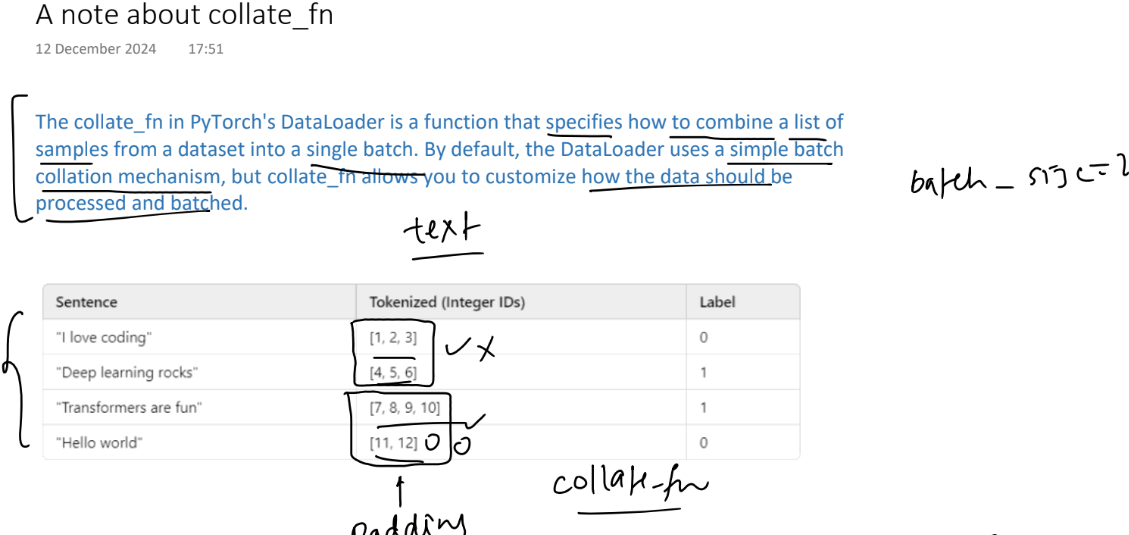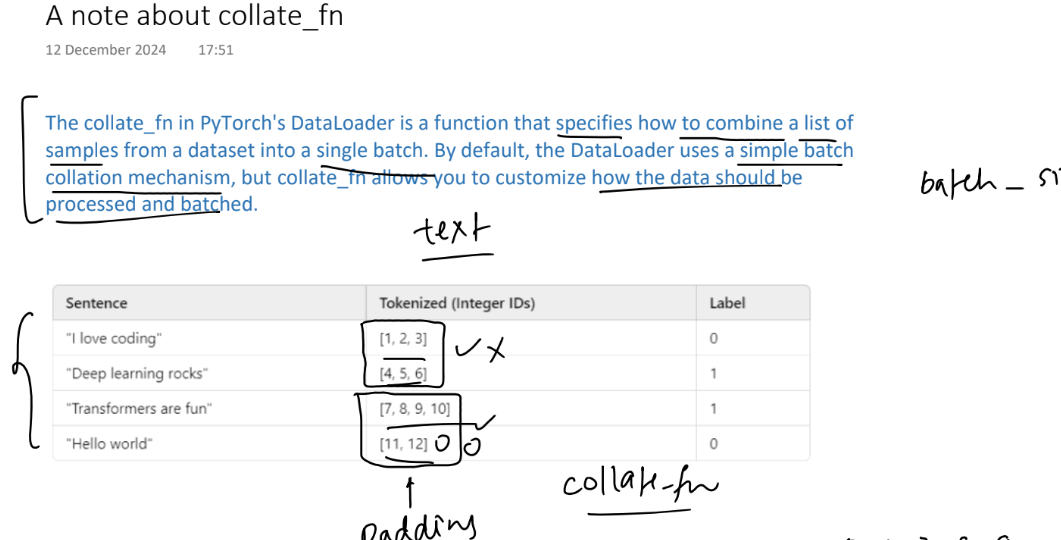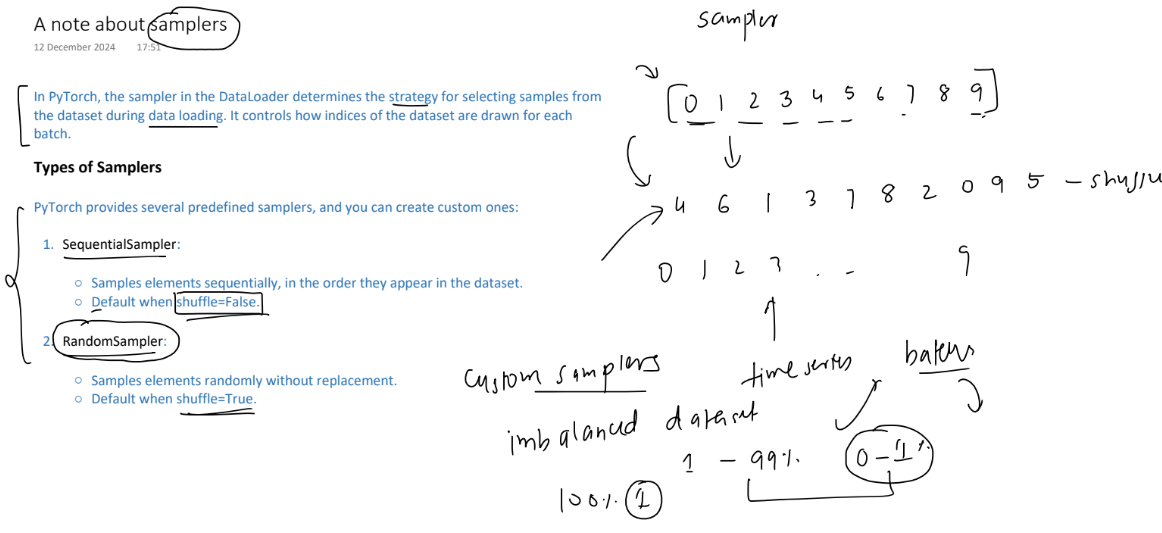